# Resumes PDFs Text Analysis

In [25]:
import fitz
import pandas as pd
import numpy as np

## Reading Resumes PDF with PyMuPDF

In [26]:
"""text_resume_list = []
for i in range(1, 5036):
    try:
        doc = fitz.open(f"data/ResumesPDF/cv ({i}).pdf")
        page = doc[0]
        text = page.get_text()
        text_resume_list.append(text)
        doc.close()
    except Exception as e:
        print(e)"""

'text_resume_list = []\nfor i in range(1, 5036):\n    try:\n        doc = fitz.open(f"data/ResumesPDF/cv ({i}).pdf")\n        page = doc[0]\n        text = page.get_text()\n        text_resume_list.append(text)\n        doc.close()\n    except Exception as e:\n        print(e)'

In [27]:
"""for text in text_resume_list[:10]:
    print(text)
    print('\n')
    print('==========================')"""

"for text in text_resume_list[:10]:\n    print(text)\n    print('\n')\n    print('==========================')"

## Reading Resumes PDF with pdfplumber

In [ ]:
import pdfplumber

cv_text_list = []
for i in range(1, 5035):
    try:
        with pdfplumber.open(f'data/ResumesPDF/cv ({i}).pdf') as pdf:
            # Acessar a primeira página
            if pdf.pages:
                pagina = pdf.pages[0]

            # Extrair texto
            texto = pagina.extract_text()
            cv_text_list.append(texto)
    except Exception as e:
        print(e)

In [29]:
for text in cv_text_list[:10]:
    print(text)
    print('\n')
    print('==========================')

MACY WILLIAMS
DATA SCIENTIST
ABOUT
Data Scientist working on problems related to market research and customer analysis. I want to expand my arsenal of
application building and work on different kinds of problems. Looking for a role where I can work with a coordinative team
and exchange knowledge during the process.
SKILLS
Java, C++, Python, Machine Learning, Algorithms, Natural Language Processing, Deep Learning, Computer Vision, Pattern
Recognition, Data Science, Data Analysis, Software Engineer, Data Analyst, C, PySpark, Kubeflow.
PROJECTS WORK EXPERIENCE
Customer browsing patterns. One97 Communications Limited
Predict potential RTO(Return To Origin) orders for e- Data Scientist Jan 2019 to Till Date
commerce.
Detect important information from images and redact
required fields. YOLO CNN Object-detection, OCR
ACTIVITES
Insights, find anomaly or performance drop in all
possible sub-space.
Object Detection.
Predict the Insurance claim probability. Estimate the
premium amount to be charg

## Configure Spark ENV Vars

In [30]:
import os
os.environ["PYSPARK_PYTHON"] = "C:/Users/Victor Dantas/PycharmProjects/EDA_Resumes/.venv/Scripts/python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = "C:/Users/Victor Dantas/PycharmProjects/EDA_Resumes/.venv/Scripts/python.exe"

## Creating Spark Session

In [31]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EDA Resumes").master("local[*]").getOrCreate()
spark

In [80]:
resumes_data = spark.createDataFrame([(text, ) for text in cv_text_list], ['text_resume'])
resumes_data.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Data Pipeline

In [81]:
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf, col
import spacy
from pyspark.ml import Transformer

class TokenFilterChar(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(TokenFilterChar, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        def remove_single_char_tokens(tokens):
            return [t for t in tokens if len(t) > 1]

        filter_udf = udf(remove_single_char_tokens, ArrayType(StringType()))
        return df.withColumn(self.outputCol, filter_udf(col(self.inputCol)))


class NerTransformer(Transformer):
    def __init__(self, inputCol=None, outputCol=None):
        super(NerTransformer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, df):
        nlp = spacy.load("en_core_web_sm")

        def extract_entities(text):
            if isinstance(text, list):
                text = " ".join(text)
            if not isinstance(text, str):
                return []
            doc = nlp(text)
            return [str(ent.text) for ent in doc.ents]

        ner_udf = udf(extract_entities, ArrayType(StringType()))
        return df.withColumn(self.outputCol, ner_udf(col(self.inputCol)))

In [82]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

tokenizer  = RegexTokenizer(inputCol="text_resume", outputCol="words_resume", pattern="[\\s+|\\W]")
remover = StopWordsRemover(inputCol="words_resume", outputCol="words_filtered")
token_filter_char = TokenFilterChar(inputCol="words_filtered", outputCol="words_filtered")
ner_transformer = NerTransformer(inputCol="words_filtered", outputCol="words_ner")
vectorizer = CountVectorizer(inputCol=remover.getOutputCol(), outputCol="features_count")

pipeline = Pipeline(stages=[tokenizer, remover, token_filter_char, ner_transformer, vectorizer])

In [83]:
resumes_data.cache()
pipe = pipeline.fit(resumes_data)
resumes_data = pipe.transform(resumes_data)
resumes_data.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Tokens Frequency

In [37]:
pipe.stages

[RegexTokenizer_e50d1cbb1f28,
 StopWordsRemover_a85ebc8b719f,
 TokenFilterChar_1412b01e1e10,
 CountVectorizerModel: uid=CountVectorizer_edf9da33f085, vocabularySize=51789]

In [38]:
count_vec_model = pipe.stages[3]
vocab = count_vec_model.vocabulary

In [39]:
features = resumes_data.select("features_count").toPandas()["features_count"]
features_array = np.array([vec.toArray() for vec in features])

# Soma as frequências por coluna
freq_total = np.sum(features_array, axis=0)

In [40]:
import pandas as pd

freq_df = pd.DataFrame({
    "token": vocab,
    "frequency": freq_total
}).sort_values(by="frequency", ascending=False)

In [41]:
freq_df.head()

,token,frequency
0,experience,6771.0
1,work,5690.0
2,skills,5257.0
3,management,4939.0
4,company,4934.0


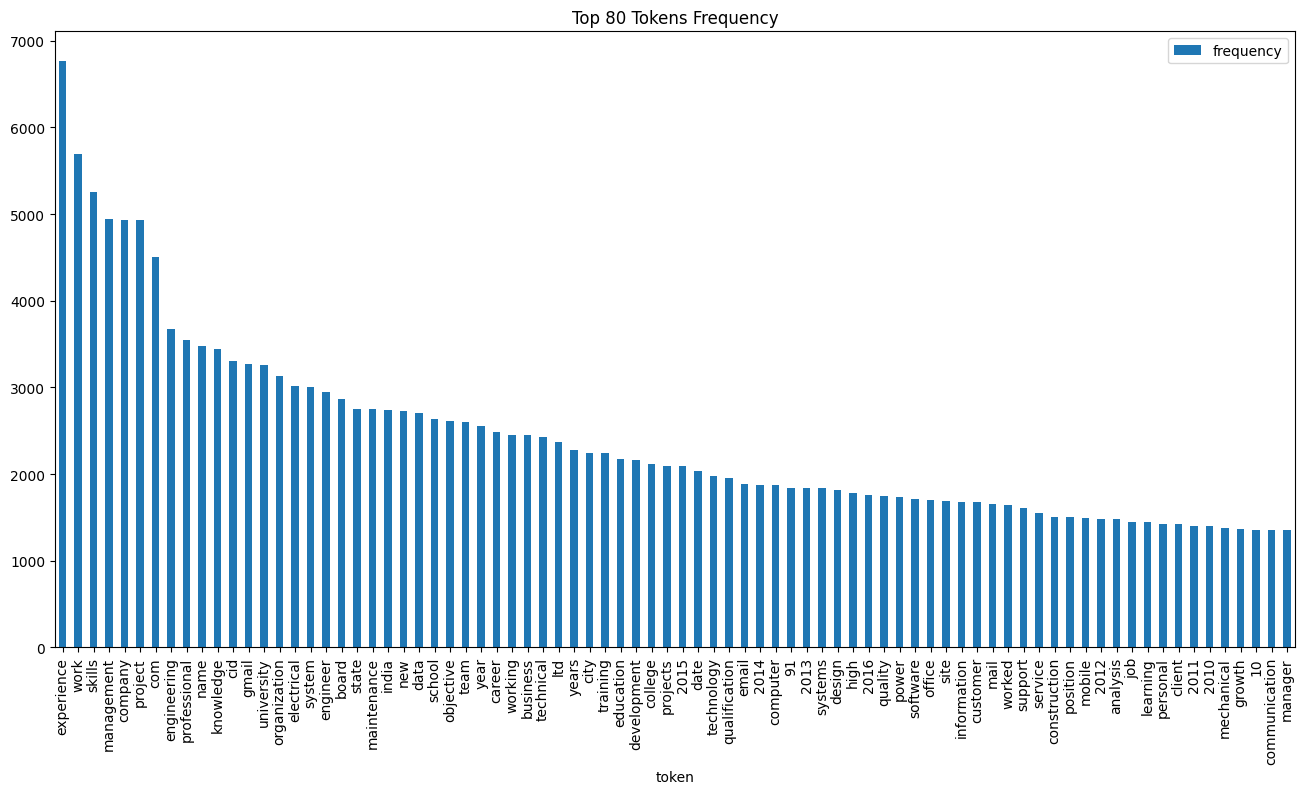

In [84]:
import matplotlib.pyplot as plt
top_k = 80
freq_df.iloc[:top_k].plot(kind="bar", x="token", y="frequency", figsize=(16, 8))
plt.xticks(rotation=90)
plt.title(f"Top {top_k} Tokens Frequency")
plt.show()

## Mean and Median Tokens By Document

In [43]:
freq_total_rows = np.sum(features_array, axis=1)
print(f'Mean of tokens by Document: {freq_total_rows.mean():.0f}')

Mean of tokens by Document: 187


In [44]:
freq_total_rows = np.sum(features_array, axis=1)
print(f'Median of tokens by Document: {np.median(freq_total_rows):.0f}')

Median of tokens by Document: 154
